---
# <center>Differences between squim NN approximations and raw metrics calculation

In [ ]:
import torch
from tqdm import tqdm
from utils import compute_reference_metrics, val_loader
from evaluation_utils import evaluate_val_set_batch, evaluate_val_set_batch_ref_vs_squim,

def evaluate_val_set_batch_ref_vs_squim(val_loader, model, evaluator, device, sample_rate=16000):
    """
    Evaluate the model on the validation set, computing both reference metrics 
    (using pesq, pystoi, and custom SI-SDR) and Squim estimated metrics.
    """

    # Lists to store metrics
    ref_stoi_list, ref_pesq_list, ref_sisdr_list = [], [], []
    est_stoi_list, est_pesq_list, est_sisdr_list = [], [], []
    
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating validation set"):
            # Extract noisy and clean from batch.
            if isinstance(batch, dict):
                noisy = batch['noisy_wave']
                clean = batch['clean_wave']
            else:
                noisy, clean = batch
                
            # If the signals are 1D, add batch dim.
            if noisy.ndim == 1:
                noisy = noisy.unsqueeze(0)  # [1, L]
                clean = clean.unsqueeze(0)
            
            # If the signals are 2D ([B, L]), add a channel dimension.
            if noisy.ndim == 2:
                noisy = noisy.unsqueeze(1)  # becomes [B, 1, L]
                clean = clean.unsqueeze(1)  
            # If noisy.ndim == 3, assume shape is [B, 1, L] already.
            
            # Move to device.
            noisy = noisy.to(device)
            clean = clean.to(device)
            output = model(noisy)  
            output = output.detach()  # Keep on device
            

            B = output.size(0)
            for i in range(B):
                denoised_i = output[i].squeeze(0).cpu().numpy()  
                clean_i = clean[i].squeeze(0).cpu().numpy()     
                
                # Compute reference metrics.
                ref_stoi, ref_pesq, ref_sisdr = compute_reference_metrics(clean_i, denoised_i, sample_rate)
                ref_stoi_list.append(ref_stoi)
                ref_pesq_list.append(ref_pesq)
                ref_sisdr_list.append(ref_sisdr)
                
                # Compute Squim estimated metrics.
                # Squim expects [batch, time] (i.e., [1, L]). Prepare the tensor accordingly.
                denoised_tensor = torch.tensor(denoised_i).unsqueeze(0).to(device)  # [1, L]
                stoi_est, pesq_est, sisdr_est = evaluator.objective_model(denoised_tensor)
                est_stoi_list.append(stoi_est.item())
                est_pesq_list.append(pesq_est.item())
                est_sisdr_list.append(sisdr_est.item())
    
    # Package reference and estimated metrics.
    ref_metrics = {
        "STOI": ref_stoi_list,
        "PESQ": ref_pesq_list,
        "SI-SDR": ref_sisdr_list
    }
    est_metrics = {
        "STOI": est_stoi_list,
        "PESQ": est_pesq_list,
        "SI-SDR": est_sisdr_list
    }
    return ref_metrics, est_metrics



In [ ]:
ref_metrics, est_metrics = evaluate_val_set_batch_ref_vs_squim(val_loader, model, DenoiserEvaluator(device=device, target_sr=SR), device, sample_rate=SR)

Evaluating validation set: 100%|██████████| 215/215 [35:49<00:00, 10.00s/it]


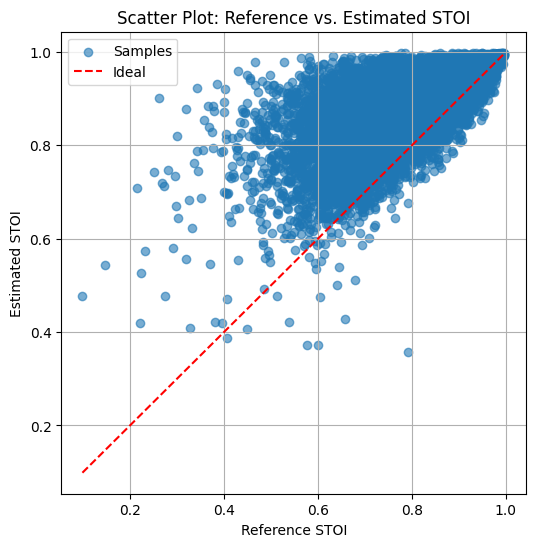

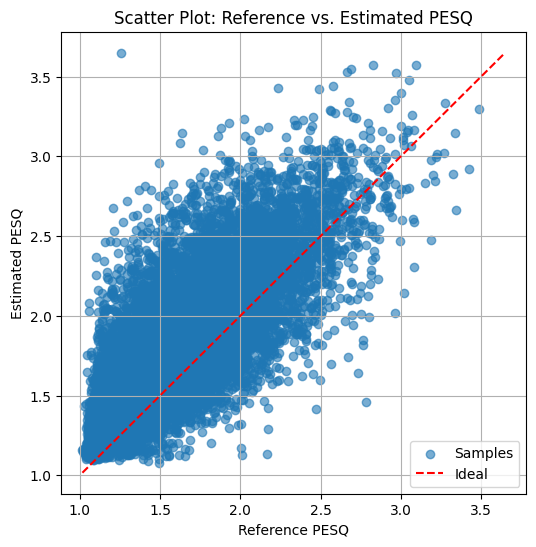

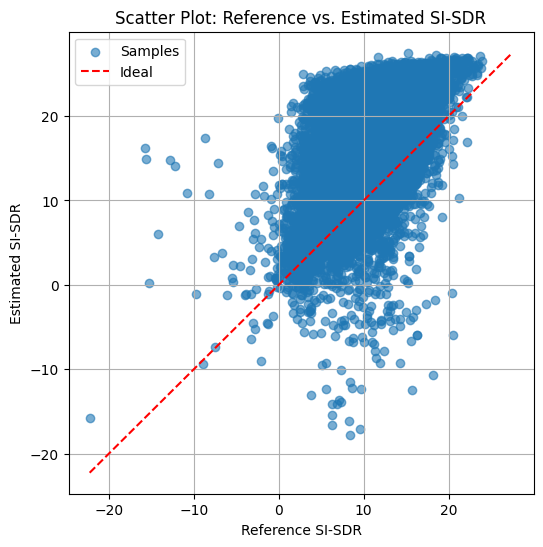

In [ ]:
scatter_plot_metric(ref_metrics["STOI"], est_metrics["STOI"], "STOI")
scatter_plot_metric(ref_metrics["PESQ"], est_metrics["PESQ"], "PESQ")
scatter_plot_metric(ref_metrics["SI-SDR"], est_metrics["SI-SDR"], "SI-SDR")